In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import glob
import multiprocessing as MP
import numpy as np
import sklearn

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.stats import mannwhitneyu

In [3]:
sns.set_style('ticks')
sns.set_palette('husl')

## Loading data

In [4]:
%%time
data_files = (
    glob.glob('../data/spaced-algorithms/*.csv')
)

print('There are {} files.'.format(len(data_files)))

There are 208 files.
CPU times: user 1.88 ms, sys: 0 ns, total: 1.88 ms
Wall time: 3.2 ms


In [5]:
%%time

# Specifying the format is ~ 10x faster.
swift_datetime_format = '%a %b %d %Y %H:%M:%S GMT+0000 (%Z)'

def _worker_read_csv(filename):
    df_tmp = pd.read_csv(filename)
    df_tmp.datecreated = pd.to_datetime(df_tmp.datecreated, 
                                        format=swift_datetime_format)
    df_tmp.dateinstallation = pd.to_datetime(df_tmp.dateinstallation, 
                                             format=swift_datetime_format)
    return df_tmp

with MP.Pool() as pool:
    df = pd.concat(pool.map(_worker_read_csv, data_files))

# df = pd.concat([pd.read_csv(f) for f in data_files])
# df.datecreated = pd.to_datetime(df.datecreated)
# df.dateinstallation = pd.to_datetime(df.dateinstallation)

CPU times: user 9.18 s, sys: 6.88 s, total: 16.1 s
Wall time: 44.2 s


In [6]:
%%time
multi_algo_users = df.groupby('user').algorithm.nunique()
ignore_users = set(multi_algo_users[multi_algo_users > 1].reset_index().user.tolist())

CPU times: user 21.9 s, sys: 3.57 s, total: 25.5 s
Wall time: 25.5 s


In [7]:
%%time
df2 = (
    df[~df.user.isin(ignore_users)]
    .rename(columns={
        'correct': 'p_recall', 
        'datecreated': 'timestamp',
        'user': 'user_id',
        'question': 'lexeme_id',
        'count': 'history_seen',
        'language': 'learning_language'
    })
)

df2['ui_language'] = 'de'
df2['lexeme_string'] = df2['lexeme_id']
df2['session_seen'] = 1
df2['session_correct'] = df2['p_recall']
df2['timestamp'] = df2['timestamp'].values.astype(np.int64) // 10 ** 9
df2.sort_values(by=['user_id', 'lexeme_id', 'timestamp'], inplace=True)

df2['delta'] = df2['timestamp'].diff()
df2.loc[(df2.lexeme_id != df2.lexeme_id.shift()) | (df2.user_id != df2.user_id.shift()), 'delta'] = None

CPU times: user 27.8 s, sys: 9.6 s, total: 37.4 s
Wall time: 37.4 s


## Binned empirical forgetting rates

In [8]:
%%time
duration_grp = df2.groupby(['lexeme_id', 'user_id'])
duration_df = (duration_grp.timestamp.last() - duration_grp.timestamp.first()).to_frame('timestamp')
attempts_df = duration_grp.size().to_frame('attempts')
attempt_duration = duration_df.join(attempts_df)

CPU times: user 18.7 s, sys: 1.64 s, total: 20.4 s
Wall time: 20.4 s


In [9]:
long_term_users = set(duration_df[duration_df.timestamp > 3 * (1 - 0.25) * 86400].reset_index().user_id.unique().tolist())

In [10]:
def limit_duration(days, alpha, attempts_exact=None):
    secs = days * 24 * 60 * 60
    lim = attempt_duration[(secs * (1 - alpha) < attempt_duration.timestamp) & (attempt_duration.timestamp < secs * (1 + alpha))]
    if attempts_exact is not None:
        lim = lim[lim.attempts == attempts_exact]
    
    lim = lim.reset_index()
    valid_tuples = set((lim.lexeme_id + '/' + lim.user_id).values)
    df_dur = df2[(df2.lexeme_id + '/' + df2.user_id).isin(valid_tuples)]
    return df_dur

In [11]:
%%time
P_MIN, P_MAX = 0.01, 0.99

lexeme_init_grp = df2.sort_values('timestamp').groupby(['lexeme_id', 'user_id'])
lexeme_initial = lexeme_init_grp.nth(2)
lexeme_first = lexeme_init_grp.nth(1)
lexeme_first_delta = (lexeme_initial.timestamp - lexeme_first.timestamp).dropna().to_frame('t_diff').reset_index()
lexeme_initial = lexeme_initial.reset_index()

lexeme_user_initial = lexeme_initial.copy()
lexeme_user_initial['user_lexeme'] = lexeme_user_initial['user_id'] + '/' + lexeme_user_initial['lexeme_id']

lexeme_user_initial['emp_n0'] = (
    - np.log(np.maximum(P_MIN, np.minimum(P_MAX, lexeme_user_initial.p_recall.values.squeeze()))) /
    (lexeme_first_delta.t_diff.values / (24 * 60 * 60))
)
lexeme_user_initial = lexeme_user_initial.set_index('user_lexeme')

lexeme_emp_n0 = lexeme_user_initial.groupby('lexeme_id').emp_n0.mean()

CPU times: user 33.8 s, sys: 7.88 s, total: 41.7 s
Wall time: 41.7 s


Example of how to bucket and calculate metrics.

In [12]:
days, N = 3, 5
grp = limit_duration(days=days, alpha=0.1, attempts_exact=None).sort_values('timestamp').groupby(['lexeme_id', 'user_id'])
nth = grp.nth(N)
n_1th = grp.nth(N - 1)
delta = (nth.timestamp - n_1th.timestamp).dropna().to_frame('t_diff').reset_index()
nth = nth.reset_index()
nth['emp_n'] = -np.log(np.maximum(P_MIN, np.minimum(P_MAX, nth['p_recall']))) / (delta.t_diff.values / (24 * 60 * 60))


In [13]:
NORM_BY_INIT_N0 = True

pm_frac = 0.25

import warnings

def _empirical_n_worker(params):
    days, N = params
    grp = limit_duration(days=days, alpha=pm_frac, attempts_exact=None).sort_values('timestamp').groupby(['lexeme_id', 'user_id'])
    nth = grp.nth(N)
    n_1th = grp.nth(N - 1)
    delta = (nth.timestamp - n_1th.timestamp).dropna().to_frame('t_diff').reset_index()
    nth = nth.reset_index()
    
    lexeme_emp_m = nth.groupby('lexeme_id').p_recall.mean()
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        nth['emp_n'] = -np.log(np.maximum(P_MIN, np.minimum(P_MAX, nth['p_recall']))) / (delta.t_diff.values / (24 * 60 * 60))
        if NORM_BY_INIT_N0:
            nth['emp_n'] /= lexeme_emp_n0.loc[nth.lexeme_id].values
        
    ssig = {}
    try:
        for alg1, alg2 in [('smart', 'random'), ('spaced', 'random'), ('spaced', 'smart')]:
            ssig[(alg1, alg2)] = mannwhitneyu(nth.emp_n[nth.algorithm == alg1], nth.emp_n[nth.algorithm == alg2])
            
        desc = (
            nth # [
                # nth.lexeme_id.isin(lexeme_emp_m.index[lexeme_emp_m > 0]) &
                # nth.lexeme_id.isin(lexeme_initial_m.index[lexeme_initial_m > 0])
                # ]
            .groupby('algorithm')
            .emp_n
            .describe()
        )
    except Exception:
        desc = None
    
    valid_lexeme_num = nth.lexeme_id.nunique()
    return days, N, valid_lexeme_num, desc, ssig

In [14]:
%%time
lexeme_data_2 = []
# P_VALUE = 0.05
P_VALUE = 0.05 / 36  # The Bonferroni procedure, m = number of tests = 36
# P_VALUE = 1 - (1 - 0.05) ** (1 / 36) # The Šidák procedure

with MP.Pool() as pool:
    for days, N, valid_lexeme_num, desc, ssig in pool.map(
        _empirical_n_worker,
        [(days, N) for days in [3, 5, 9] for N in range(3, 9)]
    ):
        if desc is not None:
            lexeme_data_2.append({
                'N': N,
                'days': days,
                'valid_lexeme_num': valid_lexeme_num,
                'smart_random_sig': ssig[('smart', 'random')].pvalue < P_VALUE,
                'spaced_smart_sig': ssig[('spaced', 'smart')].pvalue < P_VALUE,
                'spaced_random_sig': ssig[('spaced', 'random')].pvalue < P_VALUE,
            })
            
            for alg in ['smart', 'random', 'spaced']:
                for field in ['count', '25%', '50%', '75%', 'mean']:
                    lexeme_data_2[-1][f'{alg}_{field}'] = desc[field][alg]

CPU times: user 96.2 ms, sys: 7.35 s, total: 7.44 s
Wall time: 19.4 s


In [15]:
binned_df_2 = pd.DataFrame(lexeme_data_2)

In [16]:
print(f"spaced median empirical forgetting rate is better in {round(binned_df_2[binned_df_2['spaced_50%'] < binned_df_2['smart_50%']].shape[0] / binned_df_2.shape[0] * 100., 1)}% of the cases against smart.")

spaced median empirical forgetting rate is better in 83.3% of the cases against smart.


In [17]:
print(f"spaced median empirical forgetting rate is better in {round(binned_df_2[(binned_df_2['spaced_50%'] < binned_df_2['smart_50%']) & (binned_df_2['spaced_smart_sig'])].shape[0] / binned_df_2.shape[0] * 100., 1)}% of the cases against smart and the decrease is statistically significant.")

spaced median empirical forgetting rate is better in 72.2% of the cases against smart and the decrease is statistically significant.


In [18]:
print(f"spaced median empirical forgetting rate is better in {round(binned_df_2[binned_df_2['spaced_50%'] < binned_df_2['random_50%']].shape[0] / binned_df_2.shape[0] * 100., 1)}% of the cases against random.")

spaced median empirical forgetting rate is better in 83.3% of the cases against random.


In [19]:
print(f"spaced median empirical forgetting rate is better in {round(binned_df_2[(binned_df_2['spaced_50%'] < binned_df_2['random_50%']) & (binned_df_2['spaced_random_sig'])].shape[0] / binned_df_2.shape[0] * 100., 1)}% of the cases against random and the decrease is statistically significant.")

spaced median empirical forgetting rate is better in 61.1% of the cases against random and the decrease is statistically significant.


In [20]:
(binned_df_2[(binned_df_2['spaced_50%'] < binned_df_2['random_50%']) & (binned_df_2['spaced_random_sig'])].shape[0] + binned_df_2[(binned_df_2['spaced_50%'] < binned_df_2['smart_50%']) & (binned_df_2['spaced_smart_sig'])].shape[0]) / (2 * binned_df_2.shape[0])

0.6666666666666666

Comparing median decrease in normalized empirical forgetting rate and median increase in the half-life of 'spaced' against 'random'.

In [21]:
1 - (binned_df_2['spaced_50%'] / binned_df_2['random_50%']).median()

0.4801462337059099

In [22]:
1. / (binned_df_2['spaced_50%'] / binned_df_2['random_50%']).median()

1.923617880329606

In [23]:
(1. / (binned_df_2['spaced_50%'] / binned_df_2['random_50%'])).median()

1.9236334147366407

Comparing median decrease in normalized empirical forgetting rate and median increase in the half-life of 'spaced' against 'smart'.

In [24]:
1 - (binned_df_2['spaced_50%'] / binned_df_2['smart_50%']).median()

0.4094175923621066

In [25]:
1. / (binned_df_2['spaced_50%'] / binned_df_2['smart_50%']).median()

1.6932437997935332

In [26]:
(1. / (binned_df_2['spaced_50%'] / binned_df_2['smart_50%'])).median()

1.697376781839326

In [27]:
# Create figure and axes

def label_diff(algo, X, Y_1, Y_2, W, repetitions, day):
    for i in range(repetitions):
        is_sig = binned_df_2[(binned_df_2.days == day)]['spaced_' + algo + '_sig'].values[i]
        y = 1.1 * max(Y_1[i], Y_2[i])

        props = {
            'connectionstyle': 'bar',
            'arrowstyle': '-',
            'shrinkA': 0,
            'shrinkB': 0,
            'linewidth': 0.6,
            'color': 'black'
        }

        if is_sig:
            plt.gca().annotate("*", xy=(X[i] - W / 2 - 0.02, y * 1.2), zorder=10, fontsize=13)
        plt.gca().annotate('', xy=(X[i] - W, y), xytext=(X[i] + 0.25 * W, y), color='k',
                           arrowprops=props)

ALG_LABEL = {
    'spaced': r'\textsc{Select}',
    'smart': 'difficulty',
    'random': 'random'
}

def plot_day_perf(day, with_ylabel=True, with_legend=True):
    clrs = sns.color_palette('Set2', n_colors=3)
    df_plot = binned_df_2[(binned_df_2.days == day)]
    for idx, alg in enumerate(['random', 'spaced', 'smart']):
        yerr = np.vstack([
            df_plot[f'{alg}_50%'] - df_plot[f'{alg}_25%'],
            df_plot[f'{alg}_75%'] - df_plot[f'{alg}_50%']
        ])
        plt.errorbar(
            x=df_plot['N'] - 1 - (idx - 1) * 0.2, 
            y=df_plot[f'{alg}_50%'], 
            yerr=yerr,
            color=clrs[idx],
            label=ALG_LABEL[alg],
            fmt='x',
            elinewidth=12,
            alpha=0.2,
        )
        if alg == 'random':
            label_diff(
                algo=alg, 
                X=(df_plot['N'] - 1 - (idx - 1) * 0.2).values,
                Y_1=df_plot[f'{alg}_75%'].values,
                Y_2=df_plot[f'spaced_75%'].values,
                W = 0.2,
                repetitions=df_plot.shape[0],
                day=day
            )
        elif alg == 'spaced':
             label_diff(
                algo='smart', 
                X=(df_plot['N'] - 1 - (idx - 1) * 0.2).values,
                Y_1=df_plot[f'{alg}_75%'].values,
                Y_2=df_plot[f'smart_75%'].values,
                W = 0.2,
                repetitions=df_plot.shape[0],
                day=day
            )
        plt.scatter(
            df_plot['N'] - 1 - (idx - 1) * 0.2,
            df_plot[f'{alg}_50%'],
            marker='x',
            color=clrs[idx],
            label=None
        )
    plt.yscale('log')
    plt.xlabel(r'\# reviews')
    if with_ylabel:
        plt.ylabel('$\hat{n}$' if not NORM_BY_INIT_N0 else r'${\hat{n}}\ /\ {\hat{n}_0}$')
    plt.title(f'$T = {day} \\pm {round(pm_frac * day, 1)}$ days')
    
    if with_legend:
        plt.legend(loc='lower right')
        
    sns.despine()
    plt.tight_layout()

In [28]:
fig_width = 4 * 3.39 / 1.1
fig_height = (np.sqrt(5) - 1) * 3 / 1.1
figsize = (fig_width, fig_height)

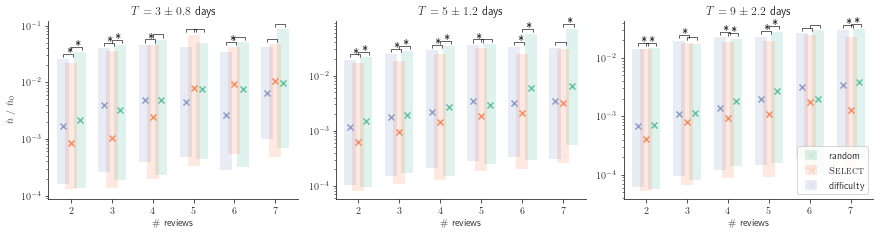

In [54]:
plt.rcParams.update({"text.usetex": True})
fig = plt.figure(figsize=figsize)
plt.subplot(131)
plot_day_perf(3, with_legend=False)
plt.subplot(132)
plot_day_perf(5, with_ylabel=False, with_legend=False)
plt.subplot(133)
plot_day_perf(9, with_ylabel=False, with_legend=True)
plt.tight_layout()
# plt.savefig('all-T.pdf', bbox_inches='tight')

## Multiple regression + Response Variance 

In [30]:
%%time
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, HuberRegressor

grp = df2[df2.algorithm.isin(['smart', 'spaced', 'random'])].groupby(['lexeme_id', 'user_id'])
one_hot_encoder = OneHotEncoder(drop=['spaced']).fit(np.array(['spaced', 'random', 'smart']).reshape(-1, 1))
reg_factory = lambda: HuberRegressor(fit_intercept=True)
# reg_factory = lambda: LinearRegression(fit_intercept=True)

first = grp.nth(1)  # The first attempt for each lexeme for each user.

coefs_ = {}
regs = {}
response_description = {}
difficulty_description = {}
ys = {}
Xs = {}
ssigs = {}

def regression(N):
    reg = reg_factory()
    nth = grp.nth(N)
    n_1th = grp.nth(N - 1)
    test_time = (nth.timestamp - n_1th.timestamp).dropna().to_frame('t_diff').reset_index()
    lexeme_users_with_tests = test_time.lexeme_id + '/' + test_time.user_id

    review_time_all = (n_1th.timestamp - first.timestamp).dropna().to_frame('time').reset_index()
    review_time = review_time_all[
        (review_time_all.lexeme_id + '/' + review_time_all.user_id)
        .isin(lexeme_users_with_tests.values)
    ]

    nth = nth.reset_index()
    nth['emp_n0'] = lexeme_emp_n0[nth.lexeme_id].values
    emp_n = (
        -np.log(np.maximum(P_MIN, np.minimum(P_MAX, nth['p_recall']))) / (test_time.t_diff.values / (24 * 60 * 60))
    )
    
     ssig = {}
     for alg1, alg2 in [('smart', 'random'), ('spaced', 'random'), ('spaced', 'smart')]:
         ssig[(alg1, alg2)] = mannwhitneyu(nth.emp_n0[nth.algorithm == alg1], nth.emp_n0[nth.algorithm == alg2])
    
    y = emp_n / lexeme_emp_n0[nth.lexeme_id].values
    T = review_time.time.values / (24 * 60 * 60)
    T_median = T - np.median(T)
    alg = nth.algorithm.values.reshape(-1, 1)
    alg_feat = one_hot_encoder.transform(alg)
    X = np.hstack([T_median.reshape(-1, 1), alg_feat.todense()])
    reg.fit(X, y)
    
    return (N, nth, y, X, reg, ssig)


with MP.Pool() as pool:
    for (N, nth, y, X, reg, ssig) in pool.map(regression, range(3, 9)):
        response_description[N] = nth.groupby('algorithm').p_recall.describe()
        difficulty_description[N] = nth.groupby('algorithm').emp_n0.describe()
        regs[N] = reg
        coefs_[N] = reg.coef_
        ys[N] = y
        Xs[N] = X
        ssigs[N] = ssig

        print(f"{N} processed.")

3 processed.
4 processed.
5 processed.
6 processed.
7 processed.
8 processed.
CPU times: user 18.3 s, sys: 15.1 s, total: 33.4 s
Wall time: 58.1 s


In [31]:
one_hot_encoder.categories_

[array(['random', 'smart', 'spaced'], dtype='<U6')]

In [32]:
one_hot_encoder.inverse_transform([[0, 0], [1, 0], [0, 1]])

array([['spaced'],
       ['random'],
       ['smart']], dtype='<U6')

In [33]:
coefs_[3].shape

(3,)

With `T - T_{median}`

In [34]:
for N in regs:
    reg = regs[N]
    print(f'FR_{N} = {reg.intercept_:0.7f} + {reg.coef_[0]:0.7f} * (T - T_{{median}}) + {reg.coef_[1]:0.7f} * I[random] + {reg.coef_[2]:0.7f} * I[smart]')

FR_3 = 0.0025851 + -0.0000198 * (T - T_{median}) + 0.0002434 * I[random] + 0.0002250 * I[smart]
FR_4 = 0.0032134 + -0.0000220 * (T - T_{median}) + 0.0001268 * I[random] + 0.0002731 * I[smart]
FR_5 = 0.0030441 + -0.0000217 * (T - T_{median}) + 0.0006490 * I[random] + 0.0006731 * I[smart]
FR_6 = 0.0030312 + -0.0000220 * (T - T_{median}) + 0.0011450 * I[random] + 0.0009979 * I[smart]
FR_7 = 0.0036860 + -0.0000226 * (T - T_{median}) + 0.0006395 * I[random] + 0.0007695 * I[smart]
FR_8 = 0.0038292 + -0.0000251 * (T - T_{median}) + 0.0011158 * I[random] + 0.0013460 * I[smart]


The responses are too noisy

In [35]:
response_description[3]

,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
random,93636.0,0.803291,0.397512,0.0,1.0,1.0,1.0,1.0
smart,301954.0,0.804308,0.396733,0.0,1.0,1.0,1.0,1.0
spaced,69236.0,0.801173,0.399121,0.0,1.0,1.0,1.0,1.0


In [36]:
response_description[4]

,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
random,53946.0,0.810829,0.391648,0.0,1.0,1.0,1.0,1.0
smart,181162.0,0.808210,0.393710,0.0,1.0,1.0,1.0,1.0
spaced,44425.0,0.811548,0.391077,0.0,1.0,1.0,1.0,1.0


In [37]:
response_description[5]

,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
random,33815.0,0.82351,0.381242,0.0,1.0,1.0,1.0,1.0
smart,118675.0,0.81242,0.390378,0.0,1.0,1.0,1.0,1.0
spaced,31207.0,0.82004,0.384160,0.0,1.0,1.0,1.0,1.0


In [38]:
response_description[6]

,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
random,22650.0,0.830022,0.375622,0.0,1.0,1.0,1.0,1.0
smart,82305.0,0.815054,0.388256,0.0,1.0,1.0,1.0,1.0
spaced,22573.0,0.830151,0.375508,0.0,1.0,1.0,1.0,1.0


In [39]:
response_description[7]

,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
random,15799.0,0.837901,0.368553,0.0,1.0,1.0,1.0,1.0
smart,59107.0,0.816671,0.386939,0.0,1.0,1.0,1.0,1.0
spaced,17089.0,0.831529,0.374295,0.0,1.0,1.0,1.0,1.0


In [40]:
response_description[8]

,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
random,11289.0,0.842944,0.363869,0.0,1.0,1.0,1.0,1.0
smart,44535.0,0.821107,0.383267,0.0,1.0,1.0,1.0,1.0
spaced,13514.0,0.840018,0.366603,0.0,1.0,1.0,1.0,1.0


Median difficulty of `spaced` is larger than `smart` and the difference is statistically significant.
But the difference is less extreme between `spaced` and `random`.

In [41]:
difficulty_description[3]

,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
random,93636.0,156.389901,315.457521,0.000257,41.515357,100.821579,196.468424,5696.039452
smart,301954.0,152.335195,335.913867,0.000305,35.744616,94.241640,184.925492,5696.039452
spaced,69236.0,156.670494,320.449471,0.002473,41.891584,101.266918,195.875268,5696.039452


In [42]:
difficulty_description[4]

,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
random,53946.0,161.463943,331.015418,0.003677,41.891584,101.985193,197.803668,5696.039452
smart,181162.0,154.025928,336.966692,0.000305,38.496791,95.898215,186.077401,5696.039452
spaced,44425.0,157.616913,308.254542,0.002711,41.891584,103.393861,197.803668,5422.140080


In [43]:
difficulty_description[5]

,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
random,33815.0,162.075510,324.949744,0.003677,41.891584,103.827552,198.983210,5696.039452
smart,118675.0,153.174289,327.530755,0.002711,38.624822,96.597275,185.387810,5696.039452
spaced,31207.0,158.482178,312.713507,0.002727,41.891584,104.208995,197.803668,5422.140080


In [44]:
difficulty_description[6]

,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
random,22650.0,159.055326,315.561502,0.003677,41.515357,102.890631,196.468424,5074.677048
smart,82305.0,154.136428,332.763470,0.002711,38.624822,96.685378,183.847002,5696.039452
spaced,22573.0,160.029695,319.592537,0.003107,42.127365,106.071437,197.924957,5422.140080


In [45]:
difficulty_description[7]

,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
random,15799.0,155.326173,308.043959,0.014519,41.515357,101.187132,191.373765,5074.677048
smart,59107.0,154.350271,331.020767,0.003677,40.324890,97.904414,183.279687,5696.039452
spaced,17089.0,159.954807,311.201253,0.003107,41.891584,106.071437,200.072901,5422.140080


In [46]:
ssigs

{3: {('smart',
   'random'): MannwhitneyuResult(statistic=1603752.0, pvalue=0.26206792498748166),
  ('spaced',
   'random'): MannwhitneyuResult(statistic=287797.5, pvalue=8.165173812281938e-05),
  ('spaced',
   'smart'): MannwhitneyuResult(statistic=1114062.0, pvalue=2.6892165135626432e-05)},
 4: {('smart',
   'random'): MannwhitneyuResult(statistic=1603752.0, pvalue=0.26206792498748166),
  ('spaced',
   'random'): MannwhitneyuResult(statistic=287797.5, pvalue=8.165173812281938e-05),
  ('spaced',
   'smart'): MannwhitneyuResult(statistic=1114062.0, pvalue=2.6892165135626432e-05)},
 5: {('smart',
   'random'): MannwhitneyuResult(statistic=1603752.0, pvalue=0.26206792498748166),
  ('spaced',
   'random'): MannwhitneyuResult(statistic=287797.5, pvalue=8.165173812281938e-05),
  ('spaced',
   'smart'): MannwhitneyuResult(statistic=1114062.0, pvalue=2.6892165135626432e-05)},
 6: {('smart',
   'random'): MannwhitneyuResult(statistic=1603752.0, pvalue=0.26206792498748166),
  ('spaced',
   'ran

### Individual FR plots

CPU times: user 14min 43s, sys: 14min 48s, total: 29min 31s
Wall time: 1min 7s


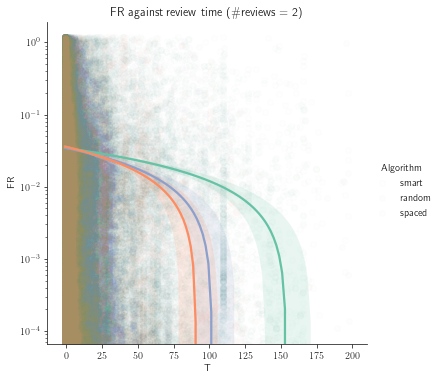

In [47]:
%%time
N = 3
(N, nth, y, X, reg, ssig) = regression(N=N)
coef_ = reg.coef_
T = np.array(X[:, 0]).squeeze()
alg = one_hot_encoder.inverse_transform(X[:, 1:]).squeeze()
idx = (y < np.percentile(y, 95))  # Reject the top x% of values.
clrs = sns.color_palette('Set2', n_colors=3)
color_map = {'smart': clrs[0], 'spaced': clrs[1], 'random': clrs[2]}
plot_data = pd.DataFrame.from_records([{'Algorithm': algo, 'T': T, 'FR': fr} for (algo, T, fr) in zip(alg.squeeze()[idx], T[idx], y[idx])])
splot = sns.lmplot(x="T", y="FR", hue="Algorithm", data=plot_data, palette=color_map, scatter_kws={'alpha': 0.01})
splot.set(yscale='log') # , xscale='log')
splot.set(title=f'FR against review time (\\#reviews = {N - 1})')

In [48]:
pd.Series(T).describe()

count    464826.000000
mean          5.227634
std          14.957487
min          -1.051030
25%          -1.001678
50%           0.000000
75%           4.089777
max         199.929444
dtype: float64

In [49]:
lexeme_emp_n0.describe()

count    1799.000000
mean      119.546290
std       338.516848
min         0.000257
25%         2.061961
50%        40.590857
75%       132.207625
max      5696.039452
Name: emp_n0, dtype: float64

In [50]:
y.describe()

count    4.648260e+05
mean     1.786863e+00
std      5.102000e+01
min      1.415011e-08
25%      4.728363e-05
50%      5.974014e-04
75%      1.447973e-02
max      1.551676e+04
Name: p_recall, dtype: float64

In [51]:
nth['p_recall'].value_counts()

1    373551
0     91275
Name: p_recall, dtype: int64

In [52]:
alg.shape, T.shape, y.shape

((464826,), (464826,), (464826,))

In [53]:
np.percentile(y, 95)

1.2058436365090057